In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

harris_p1 = pd.read_csv('data/Option 1/HarrisPartI.csv')
harris_p2 = pd.read_csv('data/Option 1/HarrisPartII.csv')
harris_p3 = pd.read_csv('data/Option 1/HarrisPartIII.csv')
vandenberg = pd.read_csv('data/Option 1/vandenBerg_table2.csv')
krause = pd.read_csv('data/Option 1/Krause21.csv')

### CSV File Information
#### Harris Part I (Identifications and Positional Data)
- 1 ['ID'] Cluster identification number
- 2 ['Name'] Other commonly used cluster name
- 3,4 ['RA'], ['DEC'] Right ascension and declination (epoch J2000)
- 5,6 ['L'], ['B'] Galactic longitude and latitude (degrees)
- 7 ['R_sun'] Distance from Sun (kiloparsecs)
- 8 ['R_gc'] Distance from Galactic center (kpc), assuming R_0=8.0 kpc
- 9-11 ['X'], ['Y'], ['Z'] Galactic distance components X,Y,Z in kiloparsecs, in a Sun-centered coordinate system; X points toward Galactic center, Y in direction of Galactic rotation, Z toward North Galactic Pole

#### Harris Part II (Metallicity and Photometry)

1. ['ID'] - Cluster identification  
2. ['Fe_H'] - Metallicity [Fe/H]  
3. ['wt'] - Weight of mean metallicity; essentially the number of independent [Fe/H] measurements averaged together  
4. ['E_BV'] - Foreground reddening (E(B-V))  
5. ['V_HB'] - V magnitude level of the horizontal branch (or RR Lyraes)  
6. ['m_MV'] - Apparent visual distance modulus (m-M)V  
7. ['V_t'] - Integrated V magnitude of the cluster  
8. ['M_V_t'] - Absolute visual magnitude (cluster luminosity), M_V,t = V_t - (m-M)V  
9. ['U_B'] - Integrated color index U-B (uncorrected for reddening)  
10. ['B_V'] - Integrated color index B-V (uncorrected for reddening)  
11. ['V_R'] - Integrated color index V-R (uncorrected for reddening)  
12. ['V_I'] - Integrated color index V-I (uncorrected for reddening)  
13. ['spt'] - Spectral type of the integrated cluster light  
14. ['ellip'] - Projected ellipticity of isophotes, e = 1-(b/a)  


#### Harris Part III (Velocities and Structural Parameters)

1. ['ID'] - Cluster identification  
2. ['v_r'] - Heliocentric radial velocity (km/s)  
3. ['v_r_e'] - Observational (internal) uncertainty in radial velocity  
4. ['v_LSR'] - Radial velocity relative to Solar neighborhood LSR  
5. ['sig_v'] - Central velocity dispersion sig_v (km/s)  
6. ['sig_v_e'] - Observational (internal) uncertainty in velocity dispersion  
7. ['c'] - King-model central concentration, c = log(r_t/r_c); a 'c' denotes a core-collapsed cluster  
8. ['r_c'] - Core radius in arcmin  
9. ['r_h'] - Half-light radius in arcmin  
10. ['mu_V'] - Central surface brightness, V magnitudes per square arcsecond  
11. ['rho_0'] - Central luminosity density, log_10(Solar luminosities per cubic parsec)  
12. ['lg_tc'] - Core relaxation time t(r_c), in log_10(years)  
13. ['lg_th'] - Median relaxation time t(r_h), in log_10(years) 

#### Vandenburg

1. ['#NGC'] - NGC cluster identification number  
2. ['Name'] - Other commonly used cluster name  
3. ['FeH'] - Metallicity [Fe/H]  
4. ['Age'] - Age of the cluster  
5. ['Age_err'] - Age uncertainty  
6. ['Method'] - Method used for determining age  
7. ['Figs'] - Figures referenced in the study  
8. ['Range'] - Range of the measurements  
9. ['HBtype'] - Horizontal branch type  
10. ['R_G'] - Distance from Galactic center (kpc)  
11. ['M_V'] - Absolute visual magnitude  
12. ['v_e0'] - Central escape velocity  
13. ['log_sigma_0'] - Central logarithmic velocity dispersion  


<p style=
    "display: flex;
    flex-direction: column; 
    align-items: center;
    text-align: center;"
>
    <img src="images/vandenberg_variables.png" alt="vandenberg_variables" width="600px"/>
    <em>
        <br/>
        Vandenberg variables as shown in https://arxiv.org/pdf/1308.2257
    </em>
</p>

#### Krause

1. ['Class'] - Classification or category of the object  
2. ['Object'] - Object name or identification number  
3. ['AltName'] - Alternative name or designation for the object  
4. ['Mstar'] - Stellar mass (Mstar) of the object  
5. ['rh'] - Half-light radius (rh) of the object  
6. ['C5'] - Compactness parameter (C5) of the object  
7. ['Age'] - Age of the object in billions of years  
8. ['FeH'] - Metallicity of the object, typically measured as [Fe/H]  

Index(['ID', 'Name', 'RA', 'DEC', 'L', 'B', 'R_Sun', 'R_gc', 'X', 'Y', 'Z',
       'v_r', 'v_r_e', 'v_LSR', 'sig_v', 'sig_v_e', 'c', 'r_c', 'r_h', 'mu_V',
       'rho_0', 'lg_tc', 'lg_th', 'v_phi', 'E', 'Lz', '[Fe/H]'],
      dtype='object')


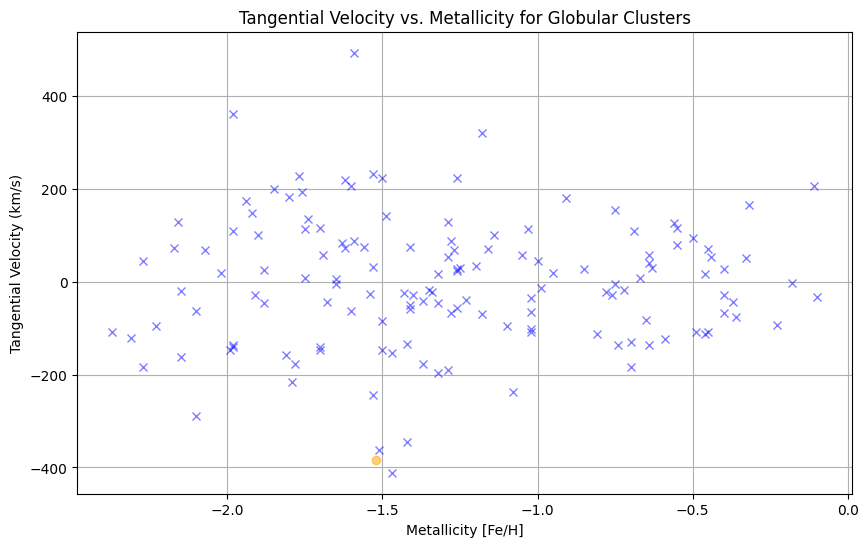

In [46]:
def calculate_orbital_properties(harris_p1, harris_p3):
    """
    Compute total energy E and z-component of angular momentum Lz for each globular cluster.

    Args:
    - harris_p1: DataFrame containing positional data and distance components.
    - harris_p3: DataFrame containing velocity data.

    Returns:
    - clusters_df: DataFrame with calculated E and Lz properties for each cluster.
    """
    # Merge the positional and velocity data based on cluster ID
    clusters_df = pd.merge(harris_p1, harris_p3, on='ID')

    # Constants (assuming certain values for the Galaxy)
    G = 4.30091e-6  # Gravitational constant in kpc (km/s)^2 / Msun
    M_gal = 6e11    # Approximate mass of the Milky Way in solar masses

    # Calculate galactocentric radius and velocities in spherical coordinates
    # clusters_df['R_gc'] = np.sqrt(clusters_df['X']**2 + clusters_df['Y']**2 + clusters_df['Z']**2)
    clusters_df['v_phi'] = clusters_df['v_r']  # Replace with tangential velocity calculation if available

    # Calculate total energy (approximate)
    clusters_df['E'] = -G * M_gal / clusters_df['R_gc'] + 0.5 * clusters_df['v_phi']**2

    # Calculate z-component of angular momentum
    clusters_df['Lz'] = clusters_df['R_gc'] * clusters_df['v_phi']  # Simplified formula for Lz, assuming unit (solar) mass

    return clusters_df

def plot_tangential_velocity_vs_metallicity(clusters_df):
    """
    Plot tangential velocity vs. metallicity for globular clusters.

    Args:
    - clusters_df: DataFrame with cluster information including metallicities and tangential velocities.
    """
    metallicities = clusters_df['[Fe/H]']
    v_phi = clusters_df['v_phi'].astype(float)
    classification = clusters_df['Classification']

    plt.figure(figsize=(10, 6))
    # plt.scatter(metallicities, v_phi, color='purple', alpha=0.7)
    
    for i in range(len(metallicities)):
        if classification[i] == 'in-situ':
            plt.plot(
            metallicities[i],
            v_phi[i],
            'x',
            alpha=0.5,
            label='in-situ',
            color='blue'
            )
        else:
            plt.plot(
            metallicities[i],
            v_phi[i],
            'o',
            alpha=0.5,
            label='in-situ',
            color='orange'
            )
            

    plt.title("Tangential Velocity vs. Metallicity for Globular Clusters")
    plt.xlabel("Metallicity [Fe/H]")
    plt.ylabel("Tangential Velocity (km/s)")
    plt.grid(True)
    plt.show()

def classify_clusters_by_ELz(clusters_df):
    """
    Classify globular clusters as in-situ or accreted based on E-Lz boundary.

    Args:
    - clusters_df: DataFrame containing computed E and Lz values.

    Returns:
    - clusters_df: Updated DataFrame with a new column 'Classification' indicating in-situ or accreted.
    """
    # Define E-Lz boundaries based on the https://arxiv.org/pdf/2309.15902 methodology
    def is_in_situ(E, Lz):
        if Lz < -0.58:
            return E < -1.3
        elif -0.58 <= Lz <= 0.58:
            return E < (-1.4 + 0.3 * Lz**2)
        else:
            return E < (-1.325 + 0.075 * Lz**2)

    clusters_df['Classification'] = clusters_df.apply(lambda row: 'in-situ' if is_in_situ(row['E'], row['Lz']) else 'accreted', axis=1)
    
    return clusters_df

def classify_by_chemical_abundance(clusters_df):
    """
    Refine classification based on chemical abundance ratios [Al/Fe] and [Mg/Fe].

    Args:
    - clusters_df: DataFrame with chemical abundances if available.

    Returns:
    - clusters_df: Updated DataFrame with a new refined classification based on chemical abundances.
    """
    # Assume we have columns for [Al/Fe] and [Mg/Fe] (replace with actual column names)
    def chemical_classification(row):
        if row['[Fe/H]'] < -1.5:
            return row['Classification']  # No clear separation at low metallicities
        elif row['[Al/Fe]'] > -0.075:
            return 'in-situ'
        else:
            return 'accreted'

    clusters_df['Chemical_Classification'] = clusters_df.apply(chemical_classification, axis=1)
    
    return clusters_df


clusters_df = calculate_orbital_properties(harris_p1, harris_p3)

# join with metallicities
harris_p2['[Fe/H]'] = pd.to_numeric(harris_p2['[Fe/H]'], errors='coerce')
clusters_df['[Fe/H]'] = harris_p2['[Fe/H]']
print(clusters_df.columns)

classify_clusters_by_ELz(clusters_df)

plot_tangential_velocity_vs_metallicity(clusters_df)
